In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

filepath = 'sample.jpg'

# Чтение изображений
На этом семинаре рассмотрим библиотеки:
* ImageIO
* Pillow
* OpenCV

Читать изображения могут не только они (могут ещё, например, Matplotlib, scikit-image), но под капотом чаще всего всё равно Pillow или OpenCV. ImageIO тоже опирается на Pillow.

## ImageIO
Простейшая библиотека, заточенная исключительно на чтение и запись. Сразу преобразовывает в numpy.ndarray.

In [2]:
import imageio.v3 as imageio

img = imageio.imread(filepath)
print(f'{img.shape = }')
print(f'{img.dtype = }')


img.shape = (955, 1280, 3)
img.dtype = dtype('uint8')


Может показаться, что любая картинка будет читаться в трёхмерный массив типа uint8, но это не так.

In [3]:
img_weird = imageio.imread('fake_and_real_peppers_ms_16.png')
print(f'{img_weird.shape = }')
print(f'{img_weird.dtype = }')

img_weird.shape = (512, 512)
img_weird.dtype = dtype('uint16')


Для вывода картинки прямо в Jupyter Notebook удобно использовать Matplotlib. Однако учитывайте, что на выходе получается png-картинка, что в случае с фотографиями влечёт утяжеление текущего ноутбука.

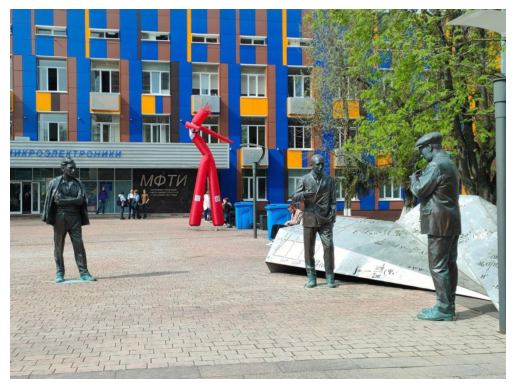

In [4]:
plt.imshow(img)
plt.axis('off')
plt.show()

Запись в файл с автоматическим определением формата.

In [5]:
imageio.imwrite('sample_copy.jpg', img)

ImageIO не поймёт, как сохранять массив типа отличного от uint8.

In [6]:
# Допустим, мы захотели сделать гамма-коррекцию.
img_float = img / np.iinfo(img.dtype).max
img_float **= 2.2
try:
    imageio.imwrite('sample_copy.jpg', img_float)
except Exception as _:
    print('Ошибка!', file=sys.stderr)

Ошибка!


In [7]:
# Специально для ImageIO значения надо приводить к uint8.
img_uint8 = (img_float * 255).astype(np.uint8)
imageio.imwrite('sample_copy.jpg', img_uint8)

## Pillow
При чтении возвращает объект своего особенного типа (не numpy.ndarray).

In [8]:
from PIL import Image

img_pil = Image.open(filepath)
type(img_pil)

PIL.JpegImagePlugin.JpegImageFile

Этот тип можно использовать для вывода картинки в Jupyter Notebook в полный размер. Однако по пути она всё же будет преобразована в png, что влечёт утяжеление ноутбука, даже большее, чем раньше.

In [9]:
# img_pil

Чтобы полноразмерно вывести картинку в виде JPEG, придётся постараться.

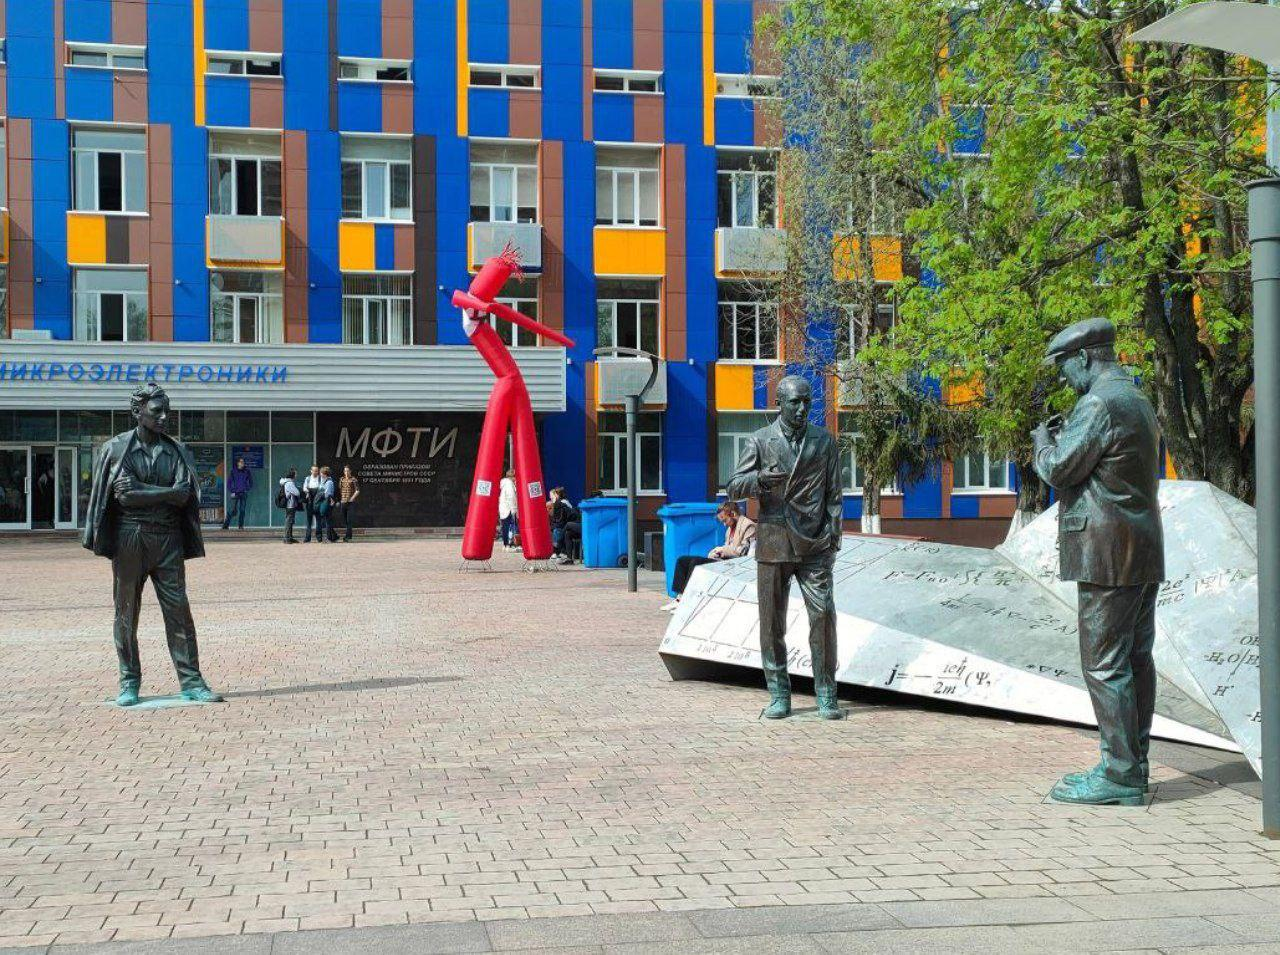

In [10]:
from IPython.display import display, Image as IPyImage
from io import BytesIO

# Сохраняем картинку в буфер, а не в файл.
buffer = BytesIO()
img_pil.save(buffer, format='JPEG')
img_bytes = buffer.getvalue()

display(IPyImage(data=img_bytes, format='jpeg'))

## OpenCV
Как мометально выстрелить себе в ногу

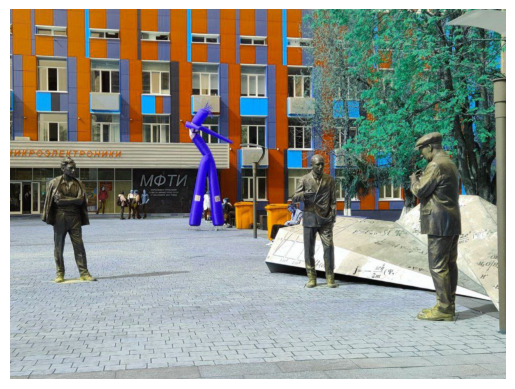

In [11]:
import cv2

img = cv2.imread(filepath)
plt.imshow(img)
plt.axis('off')
plt.show()

Что произошло? OpenCV даёт BGR вместо RGB.

Для перестановки каналов надо воспользоваться отдельной функцией

In [12]:
img = cv2.imread(filepath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Чтение метаинформации изображений

Exif &mdash; единый стандарт для хранения метаинформации в изображениях. Наиболее полного чтения можно достичь с использованием консольной утилиты `exiftool`. Для Питона есть обёртка `pyexiftool`.

In [13]:
import exiftool

with exiftool.ExifToolHelper() as et:
    metadata = et.get_metadata('Shoes-sRGB.png')
for key in metadata[0]:
    print(key, '=', metadata[0][key])

SourceFile = Shoes-sRGB.png
ExifTool:ExifToolVersion = 12.97
File:FileName = Shoes-sRGB.png
File:Directory = .
File:FileSize = 556760
File:FileModifyDate = 2025:07:10 09:39:51+02:00
File:FileAccessDate = 2025:07:10 09:47:20+02:00
File:FileInodeChangeDate = 2025:07:10 09:47:20+02:00
File:FilePermissions = 100664
File:FileType = PNG
File:FileTypeExtension = PNG
File:MIMEType = image/png
PNG:ImageWidth = 600
PNG:ImageHeight = 400
PNG:BitDepth = 8
PNG:ColorType = 2
PNG:Compression = 0
PNG:Filter = 0
PNG:Interlace = 0
Composite:ImageSize = 600 400
Composite:Megapixels = 0.24


## Цветовые профили

Достаточное описание цвета &mdash; его координаты в пространстве CIE XYZ.

Множество корректных координат (которым соответствует реально существующий цвет) имеет форму бесконечного выпуклого конуса нетривиального сечения.

Чтобы посмотреть на внутренности конуса, можно рассечь его плоскостью $X+Y+Z=1\$. Получившееся сечение &mdash; _диаграмма цветности_. Сечения, параллельные полученному, будут давать цвета других яркостей.

Каждой точке конуса можно сопоставить точку на диаграмме цветности. Для этого надо провести луч из центра координат до точки и взять пересечение с плоскостью $X+Y+Z=1$.

<img src="xyz-cone.png"><img src="color-triangle.png" style="height: 400px;">

Устройства отображения цвета (мониторы) имеют светодиоды трёх цветов, которые светятся с разной интенсивностью. Регулируя интенсивности, можно получить любой цвет, _лежащий в пределах трёхгранного конуса_, образованного первичными цветами. На диаграмме цветности это ограничение выглядит треугольником.

Trade-off: широкий цветовой охват vs. высокая стоимость светодиодов.

Чтобы говорить о цветовых координатах, надо определиться с _базисом_, в котором мы их задаём. Базис в цветовом пространстве называется _цветовым профилем_.

Как правило, подразумевается sRGB.

Но важно помнить о существовании других цветовых профилей.

### Пример

Открываем две разные картинки (убедиться в различии можно, открыв их в любом просмотрщике или браузере).

In [14]:
img_adobe_rgb = imageio.imread('Shoes-AdobeRGB.png')
img_srgb = imageio.imread('Shoes-sRGB.png')

np.all(img_adobe_rgb == img_srgb)

np.True_

А в массивы почему-то равны!

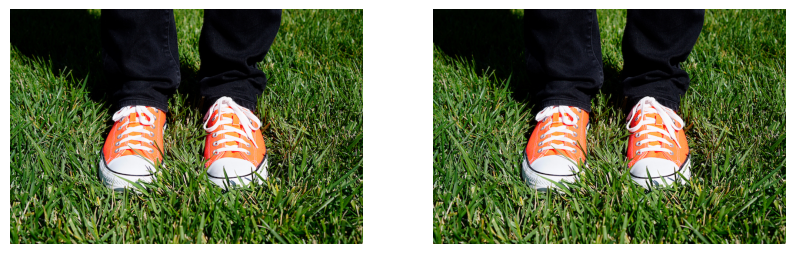

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(img_adobe_rgb)
ax[0].axis('off')
ax[1].imshow(img_srgb)
ax[1].axis('off')
plt.show()

Что произошло?
1. Мы импортировали две картинки с одинаковыми цветами, но заданными в разных цветовых пространствах. Этим объясняется различие в разнице массивов, ведь в них записаны координаты в базисе.
2. Matplotlib в обоих случаях проинтерпретировал координаты как заданные в базисе sRGB.

Из-за похожего механизма безобидная на первый взгляд операция чтения картинки и записи без изменений на самом деле может приводить к изменениям.

In [16]:
img_adobe_rgb = imageio.imread('Shoes-AdobeRGB.png')
imageio.imwrite('Shoes-AdobeRGB-copy.png', img_adobe_rgb)

Как же тогда правильно? Вот так:

In [17]:
img_adobe_rgb = imageio.imread('Shoes-AdobeRGB.png')
icc_profile = imageio.immeta('Shoes-AdobeRGB.png')['icc_profile']
imageio.imwrite('Shoes-AdobeRGB-copy.png', img_adobe_rgb, icc_profile=icc_profile)

На практике _маловероятно_, что вам попадётся картинка в цветовом профиле отличном от sRGB.

Популярность sRGB связана с тем, что это стандарт, который поддерживается большинством устройств. Чтобы узнать, поддерживает ли ваш монитор более широкие цветовые профили, можно посетить [эту замечательную страничку](https://webkit.org/blog-files/color-gamut/).

# Конвейер обработки изображений на коленке
RAW-изображения &mdash; сырые изображения камеры, не подвергшиеся конвейеру обработки.

Для работы с ними есть библиотека `rawpy`.

In [18]:
import rawpy

raw = rawpy.imread('IMG_7842.cr2')
print(f'{raw.raw_type = }\n')
print(f'{raw.color_desc = }\n')
print(f'raw.raw_pattern =\n{raw.raw_pattern}\n')
print(f'raw.raw_colors =\n{raw.raw_colors}\n')
print(f'raw.raw_image =\n{raw.raw_image}\n')

raw.raw_type = <RawType.Flat: 0>

raw.color_desc = b'RGBG'

raw.raw_pattern =
[[0 1]
 [3 2]]

raw.raw_colors =
[[0 1 0 ... 1 0 1]
 [3 2 3 ... 2 3 2]
 [0 1 0 ... 1 0 1]
 ...
 [3 2 3 ... 2 3 2]
 [0 1 0 ... 1 0 1]
 [3 2 3 ... 2 3 2]]

raw.raw_image =
[[ 3152   919   995 ...  9783 14474  3052]
 [  352   396   361 ...   294   361   399]
 [  351   376   360 ...  2054  2048  2047]
 ...
 [ 2054  2039  2039 ...  5823  6642  5577]
 [ 2052  2048  2016 ...  6795  3857  6704]
 [ 2071  2033  2052 ...  5941  6300  5173]]



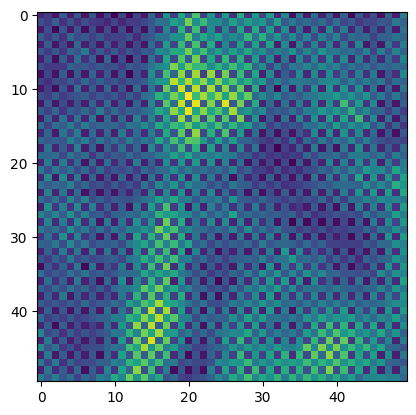

In [29]:
plt.imshow(raw.raw_image_visible[:50, :50])
plt.show()

## Шаг 1. Демозаикинг
Чтобы получить, например, значения красного канала в местах, где красный канал отсутствует, применяют интерполяцию. Мы для простоты такого делать не будем, а просто уменьшим картинку в два раза: каждый участок 2х2 превратится в один пиксель

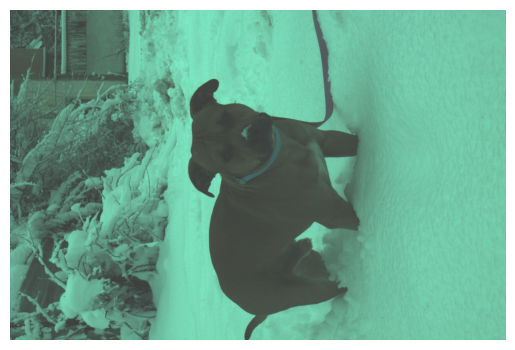

In [19]:
def flatten_bayer(img: np.ndarray):
    h, w = np.array(img.shape) // 2
    return img.reshape(h, 2, w, 2).transpose(0, 2, 1, 3).reshape(h, w, 4)
def sorting_permutation(seq):
    return list(map(
        lambda pair: pair[0],
        sorted(enumerate(seq), key=lambda pair: pair[1])
    ))

img_initial = flatten_bayer(raw.raw_image_visible)
colors_order = np.squeeze(flatten_bayer(raw.raw_pattern))
img_debayered = img_initial[..., sorting_permutation(colors_order)]

plt.imshow(img_debayered[..., :3] / img_debayered.max())
plt.axis('off')
plt.show()

## Шаг 2. Учёт темнового тока и уровня насыщения
Даже при отсутствии света матрица фотоаппарата будет регистрировать некоторый уровень сигнала, называемый _темновым током_. Также у каждого типа пикселя есть максимально возможное значение, превышение которого приводит к _насыщению_.

К счастью, данные для поправки уже есть в RAW-файле.

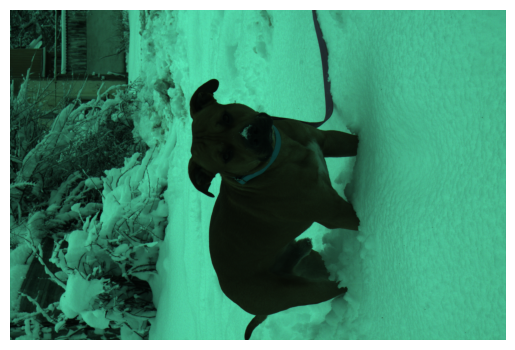

In [20]:
img_scaled = (img_debayered - raw.black_level_per_channel) /\
             (np.array(raw.camera_white_level_per_channel) - raw.black_level_per_channel)
img_scaled = np.clip(img_scaled, 0, 1)

plt.imshow(img_scaled[..., :3] / img_scaled.max())
plt.axis('off')
plt.show()

## Шаг 3. Баланс белого
В процессе съёмки камера оценивает окружающую освещённость для будущей цветокоррекции. Во-первых, это поможет отнормировать значения каналов, ибо зелёный фотодиод самый чувствительный и всегда будет давать большие значения. Во-вторых, цель фотографии &mdash; сделать максимально приятную глазу человека картинку. Зрительная система человека умеет подстраиваться под фоновое освещение, и даже при тёплом ламповом свете мы будем воспринимать лист бумаги белым. Точное же измерение цвета будет нам казаться неудовлетворительным.

Значения для настройки баланса белого хранятся в `raw.camera_whitebalance`

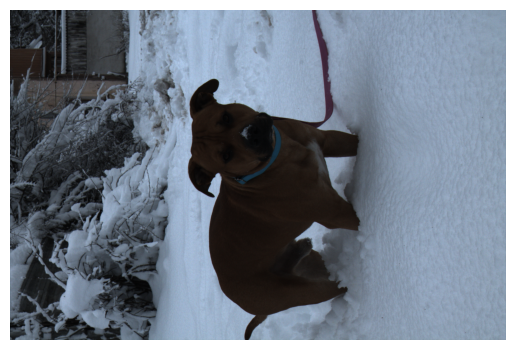

In [21]:
img_white_balanced = img_scaled * raw.camera_whitebalance / 1024

plt.imshow(img_white_balanced[..., :3] / img_white_balanced.max())
plt.axis('off')
plt.show()

## Шаг 4. Переход из цветового пространства камеры в XYZ.
Спектральные чувствительности камеры образуют своё цветовое пространство по тому же принципу, что и функции сопоставления цвета CIE XYZ. Спектры, дающие один и тот же цвет в одном пространстве, могут давать разные цвета в другом пространстве, поэтому точный переход от одного пространства к другому, вообще говоря, невозможен. Поэтому задачу подбора преобразования решают лишь приблизительно.

Матрица приблизительного перехода из XYZ в пространство камеры хранится в `raw.rgb_xyz_matrix`. Для обратного перехода понадобится обратная матрица.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010226974700679356..0.5524016035860341].


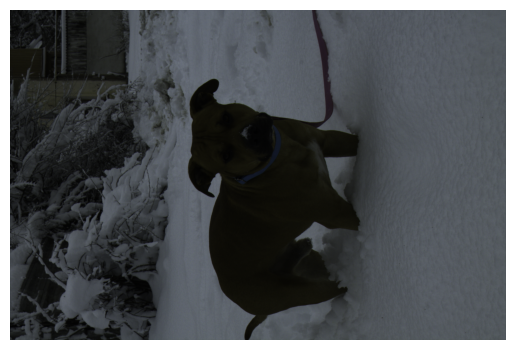

In [22]:
img_xyz = img_scaled @ np.linalg.pinv(raw.rgb_xyz_matrix).T

plt.imshow(img_xyz)
plt.axis('off')
plt.show()

## Шаг 5. Переход из XYZ в sRGB
Для отображения на мониторе нужно перейти в пространство sRGB

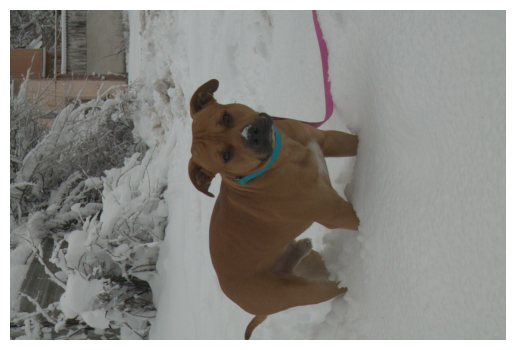

In [24]:
import colour
img_rgb = np.clip(colour.XYZ_to_sRGB(img_xyz), 0, 1)

plt.imshow(img_rgb)
plt.axis('off')
plt.show()

# Take-out messages
* Для чтения изображений достаточно библиотеки `imageio`, если вы ещё не импортировали чего-то более специфичного.
* Цветовой профиль изображения может быть нестандартным. Если это так, нужно держать в уме, что для отображения на экране нужно перейти в sRGB.
* Числа в цветовых каналах могут вылезать за пределы 0...255 в случае другой битности изображения.
* Главные шаги raw-to-SRGB пайплайна